In [1]:
import os
import laspy
import numpy as np
from tqdm import tqdm
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
import pyproj
import alphashape
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import warnings
from pyransac3d import Plane

In [2]:
# !pip install -U pyransac3d --quiet

## Loading the Data

In [3]:
data_files = [
    'USGS_LPC_AL_AGIO_B1_2016_16S_EB_2340_LAS_2018.laz',
    'USGS_LPC_AL_AGIO_B1_2016_16S_EB_2340_LAS_2018_gt_buildings.geojson',
    'USGS_LPC_CT_Statewide_C16_250890_se.laz',
    'USGS_LPC_CT_Statewide_C16_250890_se_gt_buildings.geojson',
    'USGS_LPC_GA_SW_Georgia_22_County_Lidar_2017_B17_GAW_20750320.laz',
    'USGS_LPC_GA_SW_Georgia_22_County_Lidar_2017_B17_GAW_20750320_gt_buildings.geojson',
    'USGS_LPC_IA_NorthCentral_2020_D20_w4350n4631.laz',
    'USGS_LPC_IA_NorthCentral_2020_D20_w4350n4631_gt_buildings.geojson',
    'USGS_LPC_IL_8County_2020_A20_1035_8430.laz',
    'USGS_LPC_IL_8County_2020_A20_1035_8430_gt_buildings.geojson',
    'USGS_LPC_IL_GrnMacMont_2017_2403_1011_LAS_2018.laz',
    'USGS_LPC_IL_GrnMacMont_2017_2403_1011_LAS_2018_gt_buildings.geojson',
    'USGS_LPC_IL_HicksDome_FluorsparDistrict_2019_D19_2339_5650.laz',
    'USGS_LPC_IL_HicksDome_FluorsparDistrict_2019_D19_2339_5650_gt_buildings.geojson',
    'USGS_LPC_KY_Eastern_2019_A19_e1174n1677.laz',
    'USGS_LPC_KY_Eastern_2019_A19_e1174n1677_gt_buildings.geojson',
    'USGS_LPC_MI_FEMA_2019_C19_845492.laz',
    'USGS_LPC_MI_FEMA_2019_C19_845492_gt_buildings.geojson',
]


In [4]:
file = data_files[14]
las = laspy.read(os.path.join("data",file ))
points = np.vstack((las.x, las.y, las.z)).transpose()
print(file)

USGS_LPC_KY_Eastern_2019_A19_e1174n1677.laz


## Ground Point Classification and DTM Creation

In [5]:
# Filter ground points (assuming classification is already done)
ground_mask = las.classification == 2 
ground_points = points[ground_mask]

# Create a grid for the DTM
x_min, x_max = np.min(points[:,0]), np.max(points[:,0])
y_min, y_max = np.min(points[:,1]), np.max(points[:,1])

# Define grid resolution
resolution = 1.0
x_grid = np.arange(x_min, x_max, resolution)
y_grid = np.arange(y_min, y_max, resolution)
xx, yy = np.meshgrid(x_grid, y_grid)

# Create DTM using nearest neighbor interpolation
tree = cKDTree(ground_points[:,:2])
distances, indices = tree.query(np.c_[xx.ravel(), yy.ravel()])
dtm = ground_points[indices,2].reshape(xx.shape)

## Normalize Point Cloud Heights:

In [6]:
# Find ground elevation for each point
tree = cKDTree(np.c_[xx.ravel(), yy.ravel()])
distances, indices = tree.query(points[:,:2])
ground_elevations = dtm.ravel()[indices]

# Calculate normalized heights
normalized_heights = points[:,2] - ground_elevations

# Create new LAZ file with normalized heights
new_las = laspy.create(point_format=las.header.point_format)
new_las.header = las.header
new_las.x = las.x
new_las.y = las.y
new_las.z = normalized_heights
new_las.classification = las.classification

# Save normalized point cloud
new_las.write(f"{file}_normalized.laz")

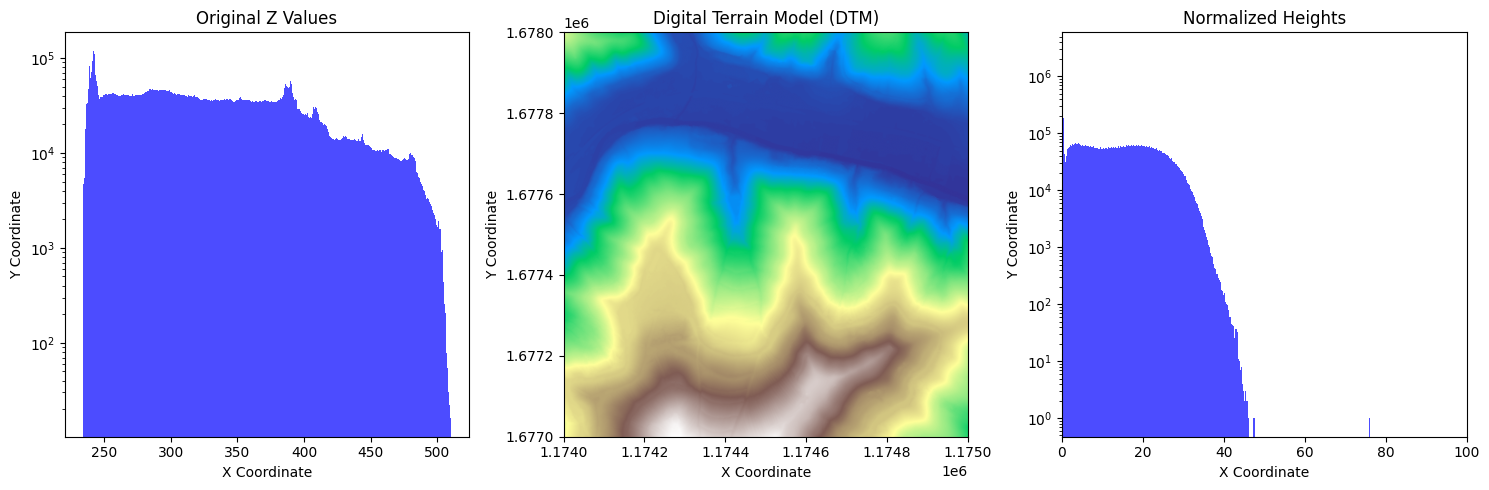

In [7]:
# Visualize original z values, DTM, and normalized heights
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(points[:,2], bins=400, color='blue', alpha=0.7)
axs[0].set_title('Original Z Values')
axs[0].set_xlabel('X Coordinate')
axs[0].set_ylabel('Y Coordinate')
axs[0].set_yscale('log')

axs[1].imshow(dtm, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='terrain')
axs[1].set_title('Digital Terrain Model (DTM)')
axs[1].set_xlabel('X Coordinate')
axs[1].set_ylabel('Y Coordinate')

axs[2].hist(normalized_heights, bins=400, color='blue', alpha=0.7)
axs[2].set_title('Normalized Heights')
axs[2].set_xlabel('X Coordinate')
axs[2].set_ylabel('Y Coordinate')
axs[2].set_yscale('log')
axs[2].set_xlim(0,100)  # Adjust x-axis limits for better visibility

plt.tight_layout()
plt.show()


## Getting Planes

### Function Definitions

In [8]:
def select_elevated_points(las, height_threshold):
    """
    Select non-ground points above specified height threshold
    """
    # Get points and classifications
    points = np.vstack((las.x, las.y, las.z)).transpose()
    classifications = las.classification
    
    # Create mask for non-ground points above threshold
    # if 6 in classifications:
    #     non_ground_mask = classifications == 6
    # else:
    non_ground_mask = classifications != 2  # TODO: noise
    heights = las.z
    height_mask = heights > height_threshold
    
    # Combine masks
    selected_points_mask = non_ground_mask & height_mask
    selected_points = points[selected_points_mask]
    return selected_points, points, selected_points_mask

def segment_buildings(points, eps, min_samples):
    """
    Segment potential building regions using DBSCAN
    """
    # Perform DBSCAN clustering
    cluster_coords = np.vstack((points[:,0], points[:,1])).T
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(cluster_coords)
    labels = clustering.labels_

    # Get unique clusters (excluding noise points labeled as -1)
    unique_labels = np.unique(labels)
    clusters = []
    
    for label in unique_labels:
        if label != -1:  # Exclude noise points
            cluster_points = points[labels == label]
            clusters.append(cluster_points)
    
    return clusters

In [9]:
def get_segments(las, height_threshold, min_inliers, n_iterations, ransac_threshold, eps, min_samples):
    # Select elevated points
    elevated_points, all_points, mask = select_elevated_points(las, height_threshold)
    # Segment into potential building regions
    building_clusters = segment_buildings(elevated_points, eps, min_samples)
    # Process each cluster
    planar_segments = []
    for cluster in tqdm(building_clusters, desc = "Processing clusters"):
        points = cluster.copy()
        if len(points) < 3:
            continue

        plane = Plane()
        best_eq, best_inliers = plane.fit(points, thresh=ransac_threshold, maxIteration=n_iterations, minPoints=min_inliers)
        
        if len(best_inliers) < min_inliers:
            continue

        inlier_points = points[best_inliers]

        planar_segments.append({
            'points': inlier_points,
            'equation': best_eq
        })

    
    return planar_segments, building_clusters


In [10]:
# Visualization function
def visualize_results(all_points, planar_segments):    
    fig = plt.figure(figsize=(12, 8))

    # Plot planar segments with different colors
    colors = plt.cm.rainbow(np.linspace(0, 1, len(planar_segments)))
    np.random.shuffle(colors)

    for segment, color in zip(planar_segments, colors):
        points = segment['points']
        plt.scatter(points[:,0], points[:,1],
                # points[:,2],
                  c=[color], s=1)
    
    plt.show()

def save_results(planar_segments,las, output_file="planar_segments.laz"):
    # Combine all planar segments
    planar_points = []
    for segment in planar_segments:
        planar_points.append(segment['points'])
    planar_points = np.vstack(planar_points)
    print(f"Planar points shape: {planar_points.shape}")
        
    # Create new LAZ file
    las_planes = laspy.create(point_format=las.header.point_format)
    las_planes.header = las.header
    las_planes.x = las.x.copy()
    las_planes.y = las.y.copy()
    las_planes.z = las.z.copy()

    # Classifying segment points as buildings (6) and rest as unclassified (0)
    las_planes.classification = np.zeros(las.x.shape, dtype=np.uint8)
    indices = np.isin(np.vstack((las_planes.x, las_planes.y, las_planes.z)).T, planar_points).all(axis=1)
    n_planar_points = 0
    for i in indices:
        if i:
            n_planar_points += 1
    las_planes.classification[indices] = 6

    print(f"Total points in planar segments: {n_planar_points} / {len(las.x)}")
    print(las_planes.classification, type(las_planes.classification))
    las_planes.write(output_file)


### Testing

In [11]:
height_threshold = 2.5  # TODO: Parameter for height threshold

# TODO: Parameters for DBSCAN
# 7
eps=2
min_samples=15

# TODO: Parameters for RANSAC
ransac_threshold = 0.6
n_iterations = 1000
min_inliers = min_samples

segments, building_clusters = get_segments(new_las, height_threshold, min_inliers, n_iterations, ransac_threshold, eps, min_samples)

Processing clusters: 100%|██████████| 448/448 [03:42<00:00,  2.02it/s]  


In [12]:
print(f"Number of building clusters: {len(building_clusters)}")
print(f"Number of planar segments: {len(segments)}")

Number of building clusters: 448
Number of planar segments: 410


#### Visualising

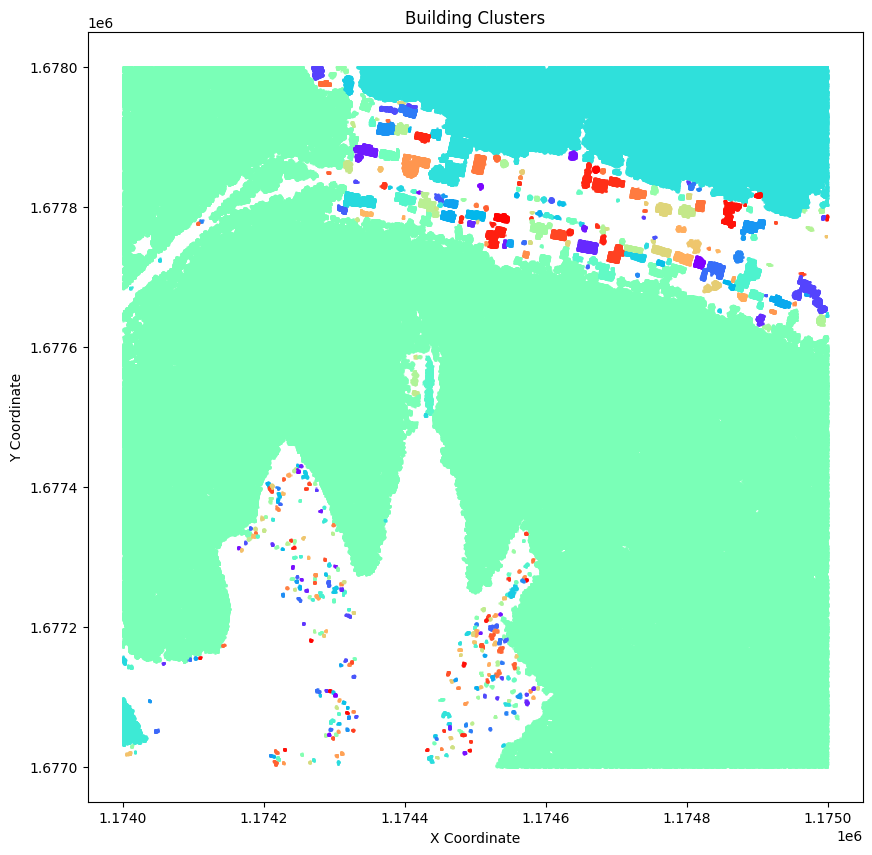

In [13]:
# View building clusters
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Building Clusters")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
colors = plt.cm.rainbow(np.linspace(0, 1, len(building_clusters)))
# Shuffle colors for better visualization
np.random.shuffle(colors)

for cluster, color in zip(building_clusters, colors):
    ax.scatter(cluster[:,0], cluster[:,1], color=color, s=1, alpha=0.5)

plt.show()

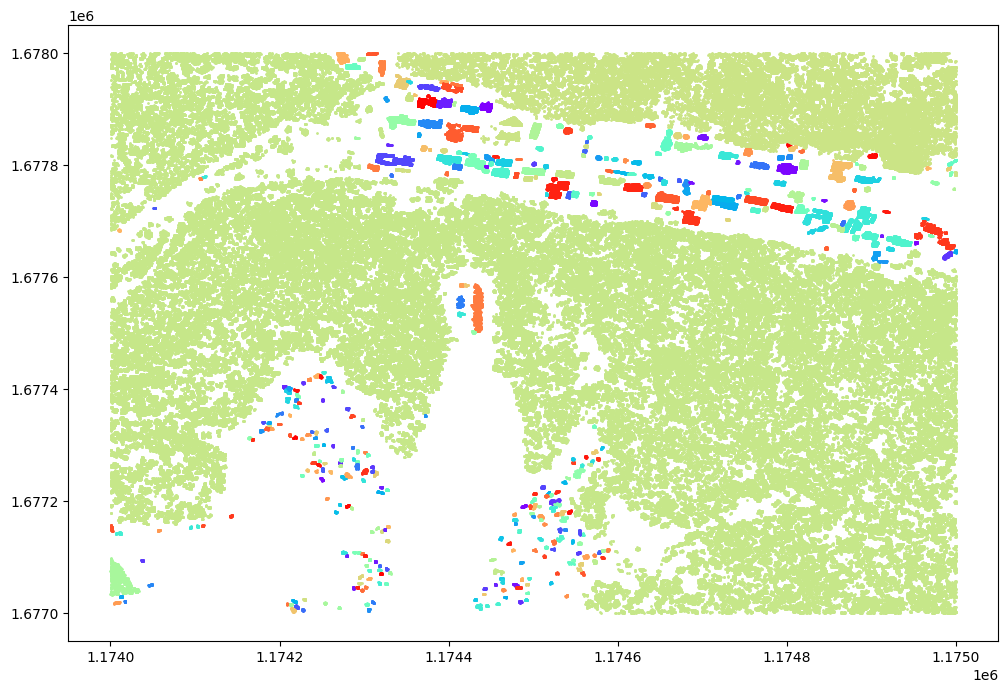

In [14]:
visualize_results(new_las.points, segments)

#### Saving

In [15]:
# save_results(segments, new_las, "planes.laz")

In [16]:
# # Load and view the saved LAZ file
# las_planes = laspy.read("planes.laz")
# print(f"Number of points in saved LAZ file: {len(las_planes.x)}")
# # Visualize the saved LAZ file
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_title("Planar Segments from Saved LAZ File")
# ax.set_xlabel("X Coordinate")
# ax.set_ylabel("Y Coordinate")
# ax.scatter(las_planes.x, las_planes.y, c=las_planes.classification, s=1, alpha=0.5)
# plt.show()


# Create alpha shapes

In [17]:
def are_points_colinear(points):
    if len(points) < 3:
        return True
    v1 = points[1] - points[0]
    for p in points[2:]:
        v2 = p - points[0]
        if np.abs(np.cross(v1, v2)) > 1e-8:
            return False
    return True

def create_polygons(planar_segments, alpha_value=1.1, min_area=3):
    polygons = []

    for segment in tqdm(planar_segments):
        cluster_points = segment['points']
        cluster_coords = np.vstack((cluster_points[:,0], cluster_points[:,1])).T
        
        if are_points_colinear(cluster_coords):
            continue
        
        try:
            alpha_shape = alphashape.alphashape(cluster_coords, alpha_value)
        
            # Process geometries and filter by area
            if isinstance(alpha_shape, Polygon):
                if alpha_shape.is_valid and not alpha_shape.is_empty:
                    area = alpha_shape.area
                    if min_area <= area :
                        polygons.append(alpha_shape)
            else:
                continue
        except:
            print("Error creating polygons")
    
    return polygons

In [18]:
alpha = 1.3
min_area = 5
warnings.filterwarnings('ignore')
polygons = create_polygons(segments,alpha_value=alpha, min_area=min_area )
print(len(polygons))
warnings.filterwarnings('default')

100%|██████████| 410/410 [01:32<00:00,  4.42it/s] 

106


In [19]:
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons, crs=new_las.header.parse_crs()).to_crs(3857)
output_file = "output2.geojson"
gdf.to_file(output_file, driver='GeoJSON')
print(f"GeoJSON saved to {output_file}")

GeoJSON saved to output2.geojson
